# Basic usage Array2DAnalysis

This notebook demonstrates the basic intended usage of the Array2DAnalysis module. 

Note, this module works best in conjuction with GEECS-Data-Utils also installed. See that project documentation to get started with it 

In [1]:
from pathlib import Path
from scan_analysis.base import ScanAnalyzerInfo as Info
from scan_analysis.execute_scan_analysis import instantiate_scan_analyzer
from image_analysis.offline_analyzers.beam_analyzer import (
    BeamAnalyzer,
    create_variation_analyzer,
)
from image_analysis.config_loader import set_config_base_dir
from geecs_data_utils import ScanTag

from scan_analysis.analyzers.common.array2D_scan_analysis import Array2DScanAnalyzer

import logging

logging.getLogger("image_analysis").setLevel(logging.WARNING)
logging.getLogger("scan_analysis").setLevel(logging.WARNING)

set_config_base_dir(
    Path(
        "D:/Users/sbarber.BELLAAPPSERVER/Documents/GitHub/GEECS-Plugins/image_analysis_configs"
    )
)

2025-10-01 15:41:03,475 - root - WARNING - Could not properly load docgen, results will not auto-populate scan log.


Failed to load config file from: D:\Users\sbarber.BELLAAPPSERVER\Documents\GitHub\GEECS-Plugins\LogMaker4GoogleDocs\logmaker_4_googledocs\config.ini


In [7]:
dev_name = "UC_Amp4_IR_input"
standard_analyzer = BeamAnalyzer(camera_config_name=dev_name)
variation_analyzer = create_variation_analyzer(
    dev_name, percentile=15.0, additional_constant=7
)

In [8]:
import time

t0 = time.monotonic()
year = 2025
month = 2
day = 20
number = 14
experiment = "Undulator"
test_tag = ScanTag(
    year=year, month=month, day=day, number=number, experiment=experiment
)

standard_analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={"image_analyzer": standard_analyzer},
)

variational_analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={"image_analyzer": variation_analyzer},
)


variational_scan_analyzer = instantiate_scan_analyzer(
    scan_analyzer_info=variational_analyzer_info
)
variational_scan_analyzer.run_analysis(scan_tag=test_tag)

standard_scan_analyzer = instantiate_scan_analyzer(
    scan_analyzer_info=standard_analyzer_info
)
standard_scan_analyzer.run_analysis(scan_tag=test_tag)

t1 = time.monotonic()
print(f"execution time: {t1 - t0}")

2025-10-01 15:48:16,333 - root - INFO - analysis path is : Z:\data\Undulator\Y2025\02-Feb\25_0220\analysis\Scan014
2025-10-01 15:48:16,339 - root - INFO - Scan parameter is: noscan.
2025-10-01 15:48:16,339 - root - WARNING - No parameter varied during the scan, setting noscan flag.


execution time: 58.562999999849126


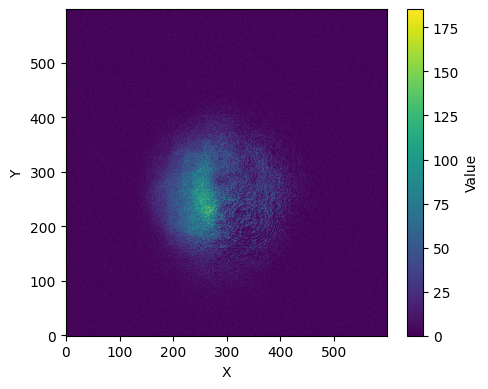

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


def show_array(array: np.ndarray, cmap: str = "viridis", title: str | None = None):
    """
    Display a 2D NumPy array as an image.

    Parameters
    ----------
    array : np.ndarray
        2D array to visualize.
    cmap : str, optional
        Colormap to use for visualization (default: 'viridis').
    title : str, optional
        Title for the plot.
    """
    if array.ndim != 2:
        raise ValueError("Input must be a 2D array")

    plt.figure(figsize=(5, 4))
    im = plt.imshow(array, cmap=cmap, origin="lower", aspect="auto")
    plt.colorbar(im, label="Value")
    if title:
        plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()


show_array(standard_scan_analyzer.results[10]["processed_image"])

In [6]:
from geecs_data_utils.scan_data import ScanData
from image_analysis.offline_analyzers.beam_analyzer import BeamAnalyzer

sd = ScanData.from_date(
    year=year, month=month, day=day, number=number, experiment=experiment
)

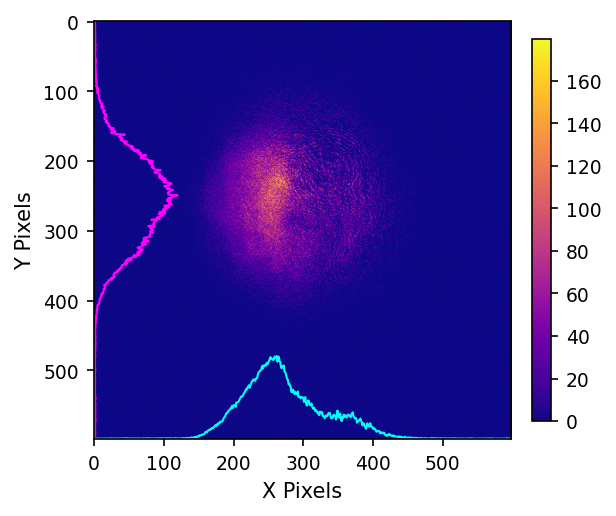

(<Figure size 600x600 with 2 Axes>,
 <Axes: xlabel='X Pixels', ylabel='Y Pixels'>)

In [20]:
analyzer = BeamAnalyzer(camera_config_name=dev_name)
file_path = sd.data_frame[f"{dev_name}_expected_path"][9]

bkg_cfg = analyzer.camera_config.background

scan_dir = sd.paths.get_folder() / dev_name
bkg_path_template = analyzer.camera_config.background.file_path
bkg_path = bkg_path_template.format_map({"scan_dir": scan_dir})

new_bkg_config = bkg_cfg
new_bkg_config.file_path = bkg_path
new_bkg_config.additional_constant = 0

analyzer.update_config(background=new_bkg_config)

results = analyzer.analyze_image_file(image_filepath=file_path)
analyzer.visualize(results)